# 0. Imports and Set Up

In [286]:
import sys
sys.path.append('../')
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import csv
import os
from itertools import zip_longest
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from scripts.evaluation_utils import evaluating_model
from scripts.visualization_utils import visual_label_dist, visual_scores_by_race
from scripts.classification_utils import load_args,prep_data,get_classifier, get_new_scores, add_constraint_and_evaluate,add_values_in_dict, save_dict_in_csv


In [287]:
data_path = '../data/synthetic_ds/Demo-0-Lab-0.csv'# path to the dataset csv-file
results_path = '../final_results/fico_data/syn_raw/00/' # directory to save the results

weight_idx = 1 # weight index for samples (1 in our runs)
testset_size = 0.3 # proportion of testset samples in the dataset (e.g. 0.3)
test_set_variant = 0 # 0= default (testset like trainset), 1= balanced testset, 2= original,true FICO distribution
test_set_bound = 30000 # absolute upper bound for test_set size

di_means = [100,-100] # means for delayed impact distributions (rewardTP,penaltyFP)
di_stds = [15,15] # standard deviations for delayed impact distributions (rewardTP,penaltyFP)

save = True # indicator if the results should be saved

models = {'Decision Tree': 'dt', 'Gaussian Naive Bayes':'gnb','Logistic Regression': 'lgr', 'Gradient_Boosted_Trees': 'gbt'}
model_name = models['Logistic Regression']

# 0. IMPORTANT--Specify classifier to be trained and dataset

In [288]:
os.makedirs(f'{results_path}{model_name}', exist_ok=True)


In [289]:
overall_results_dict = {}
black_results_dict = {}
white_results_dict = {}
all_types = []
all_scores = []
scores_names = []

# 2. Prepare data

In [290]:
data = pd.read_csv(data_path)
data[['score', 'race']] = data[['score', 'race']].astype(int)
x = data[['score', 'race']].values
y = data['repay_indices'].values

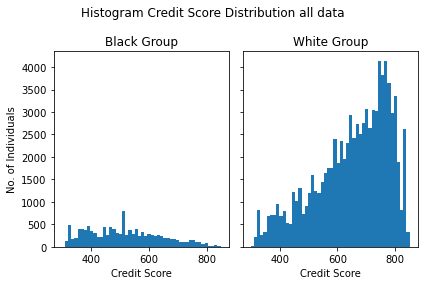

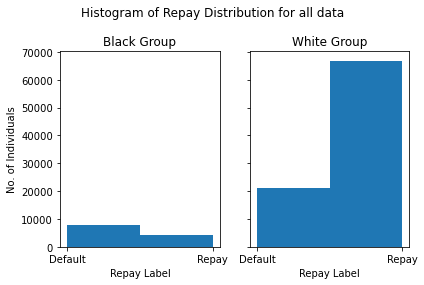

In [291]:
visual_scores_by_race(results_path,'all',x)
visual_label_dist(results_path,'all',x,y)
plt.show()

In [292]:
X_train, X_test, y_train, y_test, race_train, race_test, sample_weight_train, sample_weight_test = prep_data(data, testset_size,test_set_variant,test_set_bound, weight_idx)

 Whole set: 100000
Black N/P: 7920 / 4080 White N/P: 21120 / 66880
Training set: 70000
Black N/P: 5574 / 2888 White N/P: 14813 / 46725
Testing set: 30000
Black N/P: 2346 / 1192 White N/P: 6307 / 20155


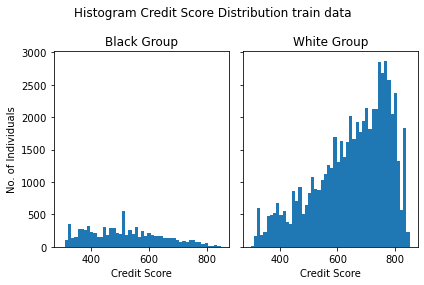

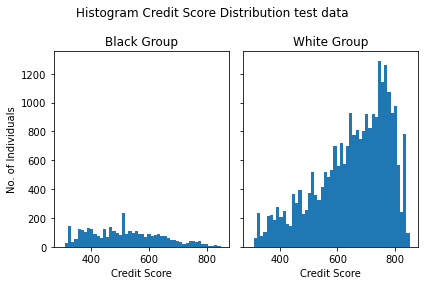

In [293]:
# make histogram of credit scores by race
visual_scores_by_race(results_path,'train',X_train)
visual_scores_by_race(results_path,'test',X_test)

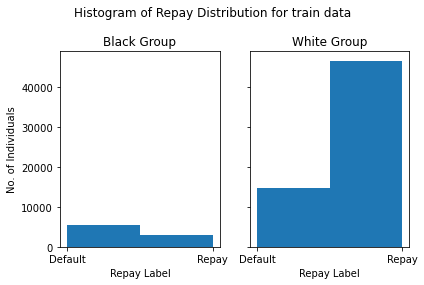

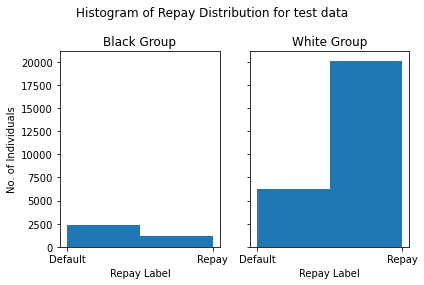

In [294]:
visual_label_dist(results_path,'train',X_train, y_train)
visual_label_dist(results_path,'test',X_test,y_test)

In [295]:
X_test_b = []
X_test_w = []
y_test_b = []
y_test_w = []


for index in range(len(X_test)):
    if race_test[index] == 0:  # black
        X_test_b.append(X_test[index][0])
        y_test_b.append(y_test[index])
    elif race_test[index] == 1:  # white
        X_test_w.append(X_test[index][0])
        y_test_w.append(y_test[index])

In [296]:
#adding scores and types to list
T_test_b = ['TP' if e==1 else "TN" for e in y_test_b]
T_test_w = ['TP' if e==1 else "TN" for e in y_test_w]
all_types.extend([T_test_b,T_test_w])
all_scores.extend([X_test_b,X_test_w])
scores_names.extend(['testB', 'testW'])

# 3. Train unmitigated model

In [ ]:
print('The classifier trained below is: ', model_name)

results_path += f'{model_name}/'

In [ ]:
classifier = get_classifier(model_name)

## Train classifier and collect predictions
NOTE: atm sample_weight are all 1s

In [ ]:
# Reference: https://www.datacamp.com/community/tutorials/decision-tree-classification-python
np.random.seed(0)

# Train the classifier:
model = classifier.fit(X_train,y_train, sample_weight_train)

# Make predictions with the classifier:
y_predict = model.predict(X_test)

# Scores on test set
test_scores = model.predict_proba(X_test)[:, 1]

### Get new scores by race

In [ ]:
# think: later on I might want to create a sheet just with the TP and FP scores by race specifically
X_unmit_b, X_unmit_w,T_unmit_b, T_unmit_w = get_new_scores(X_test, y_predict, y_test, di_means, di_stds, race_test)

In [ ]:
#adding scores to list
all_types.extend([T_unmit_b,T_unmit_w])
all_scores.extend([X_unmit_b,X_unmit_w])
scores_names.extend(['unmitB', 'unmitW'])

### Evaluation of unmitigated classification model

In [ ]:
constraint_str = 'Un-'
results_overall, results_black, results_white = evaluating_model(constraint_str,X_test,y_test, y_predict, di_means,di_stds, sample_weight_test,race_test)

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} Unmitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)

# 4. Adding Fairness Constraints - Train mitigated models

### Demographic Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint_and_evaluate(model, 'DP', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False,di_means,di_stds)

### Get new scores by race

In [ ]:
X_egDP_b, X_egDP_w,T_egDP_b, T_egDP_w = get_new_scores(X_test, y_pred_mitigated, y_test, di_means, di_stds, race_test)

In [ ]:
#adding scores to list
all_types.extend([T_egDP_b, T_egDP_w])
all_scores.extend([X_egDP_b, X_egDP_w])
scores_names.extend(['egdpB', 'egdpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} DP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)

### Equalized Odds

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint_and_evaluate(model, 'EO', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False, di_means,di_stds,)

### Get new scores by race

In [ ]:
X_egEO_b, X_egEO_w,T_egEO_b, T_egEO_w = get_new_scores(X_test, y_pred_mitigated, y_test, di_means, di_stds, race_test)

In [ ]:
#adding scores to list
all_types.extend([T_egEO_b, T_egEO_w])
all_scores.extend([X_egEO_b, X_egEO_w])
scores_names.extend(['egeoB', 'egeoW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} EO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)

### EOO (True Positive Rate Parity)

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint_and_evaluate(model, 'TPRP', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False, di_means,di_stds,)

### Get new scores by race

In [ ]:
X_egEOO_b, X_egEOO_w,T_egEOO_b, T_egEOO_w = get_new_scores(X_test, y_pred_mitigated, y_test, di_means, di_stds, race_test)

In [ ]:
#adding scores to list
all_types.extend([T_egEOO_b, T_egEOO_w])
all_scores.extend([X_egEOO_b, X_egEOO_w])
scores_names.extend(['egeooB', 'egeooW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} EOO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)

### False Positive Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint_and_evaluate(model, 'FPRP', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False, di_means,di_stds,)

### Get new scores by race

In [ ]:
X_egFPRP_b, X_egFPRP_w,T_egFPRP_b, T_egFPRP_w = get_new_scores(X_test, y_pred_mitigated, y_test, di_means, di_stds, race_test)

In [ ]:
#adding scores to list
all_types.extend([T_egFPRP_b, T_egFPRP_w])
all_scores.extend([X_egFPRP_b, X_egFPRP_w])
scores_names.extend(['egfprpB', 'egfprpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} FPRP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)

### Error Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint_and_evaluate(model, 'ERP', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False, di_means,di_stds,)

### Get new scores by race

In [ ]:
X_egERP_b, X_egERP_w,T_egERP_b, T_egERP_w = get_new_scores(X_test, y_pred_mitigated, y_test, di_means, di_stds, race_test)

In [ ]:
#adding scores to list
all_types.extend([T_egERP_b, T_egERP_w])
all_scores.extend([X_egERP_b, X_egERP_w])
scores_names.extend(['egerpB', 'egerpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} ERP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)

# 5. Save results to csv files

In [ ]:
# To use below!!
if save == True:
    overall_fieldnames = ['Run', 'Acc', 'ConfMatrix','F1micro', 'F1weighted','F1binary', 'SelectionRate', 'TNR rate', 'TPR rate', 'FNER', 'FPER', 'DIB','DIW', 'DP Diff', 'EO Diff', 'TPR Diff', 'FPR Diff', 'ER Diff']
    byrace_fieldnames = ['Run', 'Acc', 'ConfMatrix','F1micro', 'F1weighted','F1binary', 'SelectionRate', 'TNR rate', 'TPR rate', 'FNER', 'FPER', 'DI']
    save_dict_in_csv(overall_results_dict, overall_fieldnames,  results_path+model_name+'_overall_results.csv')
    save_dict_in_csv(black_results_dict, byrace_fieldnames,  results_path+model_name+'_black_results.csv')
    save_dict_in_csv(white_results_dict, byrace_fieldnames,  results_path+model_name+'_white_results.csv')

In [ ]:
if save == True:
    # Save overall score results
    columns_data_scores = zip_longest(*all_scores)
    columns_data_types = zip_longest(*all_types)

    with open(results_path+model_name+'_all_scores.csv',mode='w') as f:
            writer = csv.writer(f)
            writer.writerow(scores_names)
            writer.writerows(columns_data_scores)
            f.close()
    with open(results_path+model_name+'_all_types.csv',mode='w') as f:
        writer = csv.writer(f)
        writer.writerow(scores_names)
        writer.writerows(columns_data_types)
        f.close()